# KMeans Clustering of Topics in 3 DTMs: Raw, Stemmed, Lemmatized

First, we are going to repeat everything from the stemming notebook -- once we have a sense of which DTM we are going to use going forward, we can save it and not keep creating it.

In [6]:
import pandas as pd, re, csv, nltk, string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from itertools import combinations

In [11]:
import matplotlib.pyplot as plt

In [20]:
from labellines import labelLine, labelLines

ModuleNotFoundError: No module named 'labellines'

In [ ]:
# Imports, Functions, Stopwords
import numpy as np
import gensim
import operator
import matplotlib as mpl
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 14})


# This library makes it easy to save "interim" results so that
# we don't have to get running algorithms over and over
from sklearn.externals import joblib

In [1]:
# LOCAL FUNCTION to remove parentheticals (See Terms-O1b)
def remove_parentheticals(text):
    new_text = text
    for rgx_match in parentheticals:
        new_text = re.sub(rgx_match, ' ', new_text.lower(), flags=re.IGNORECASE)
    return new_text

parentheticals = [ "\(laughter\)", "\(applause\)", "\(music\)", "\(video\)", 
                  "\(laughs\)", "\(applause ends\)", "\(audio\)", "\(singing\)", 
                  "\(music ends\)", "\(cheers\)", "\(cheering\)", "\(recording\)", 
                  "\(beatboxing\)", "\(audience\)", "\(guitar strum\)", 
                  "\(clicks metronome\)", "\(sighs\)", "\(guitar\)", "\(marimba sounds\)", 
                  "\(drum sounds\)" ]

# DATA
# Load the dataset
df = pd.read_csv('../output/TEDall_speakers.csv')
# Grab the texts
texts = df.text.tolist()

Next, we are going to set up our three vectorizers and run them.

In [5]:
# Raw TF
raw_vectorizer = TfidfVectorizer(   lowercase = True,
                                preprocessor = remove_parentheticals, 
                                min_df = 2 )

X_raw = raw_vectorizer.fit_transform(texts)


# Stemmed TF
stemmer = nltk.PorterStemmer()
analyzer = TfidfVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))
stem_vectorizer = TfidfVectorizer(  analyzer=stemmed_words,
                                    min_df = 2,
                                    preprocessor = remove_parentheticals,
                                    lowercase = True )

X_stemmed = stem_vectorizer.fit_transform(texts)


# Lemmatized TF
wnl = nltk.WordNetLemmatizer()
analyzer = TfidfVectorizer().build_analyzer()

def lemmed_words(doc):
    return (wnl.lemmatize(w) for w in analyzer(doc))

lem_vectorizer = TfidfVectorizer(   analyzer = lemmed_words,
                                    min_df = 2,
                                    preprocessor = remove_parentheticals,
                                    lowercase = True )

X_lemmed = lem_vectorizer.fit_transform(texts)

print(f"X_raw is {X_raw.shape}. X_stemmed is {X_stemmed.shape}. X_lemmed is {X_lemmed.shape}.")

X_raw is (1747, 29340). X_stemmed is (1747, 18243). X_lemmed is (1747, 25312).


## K-Means Clustering based on TFIDF

In [7]:
def kkmeans (dtm):
    # Now let's try it for a range of possible clusters:
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42 }
    # A list holds the SSE values for each k
    sse = []
    for k in range(25, 91, 10):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(dtm)
        sse.append(kmeans.inertia_)
    return sse

In [9]:
km_raw = kkmeans(X_raw)

In [13]:
km_stemmed = kkmeans(X_stemmed)
km_lemmed = kkmeans(X_lemmed)

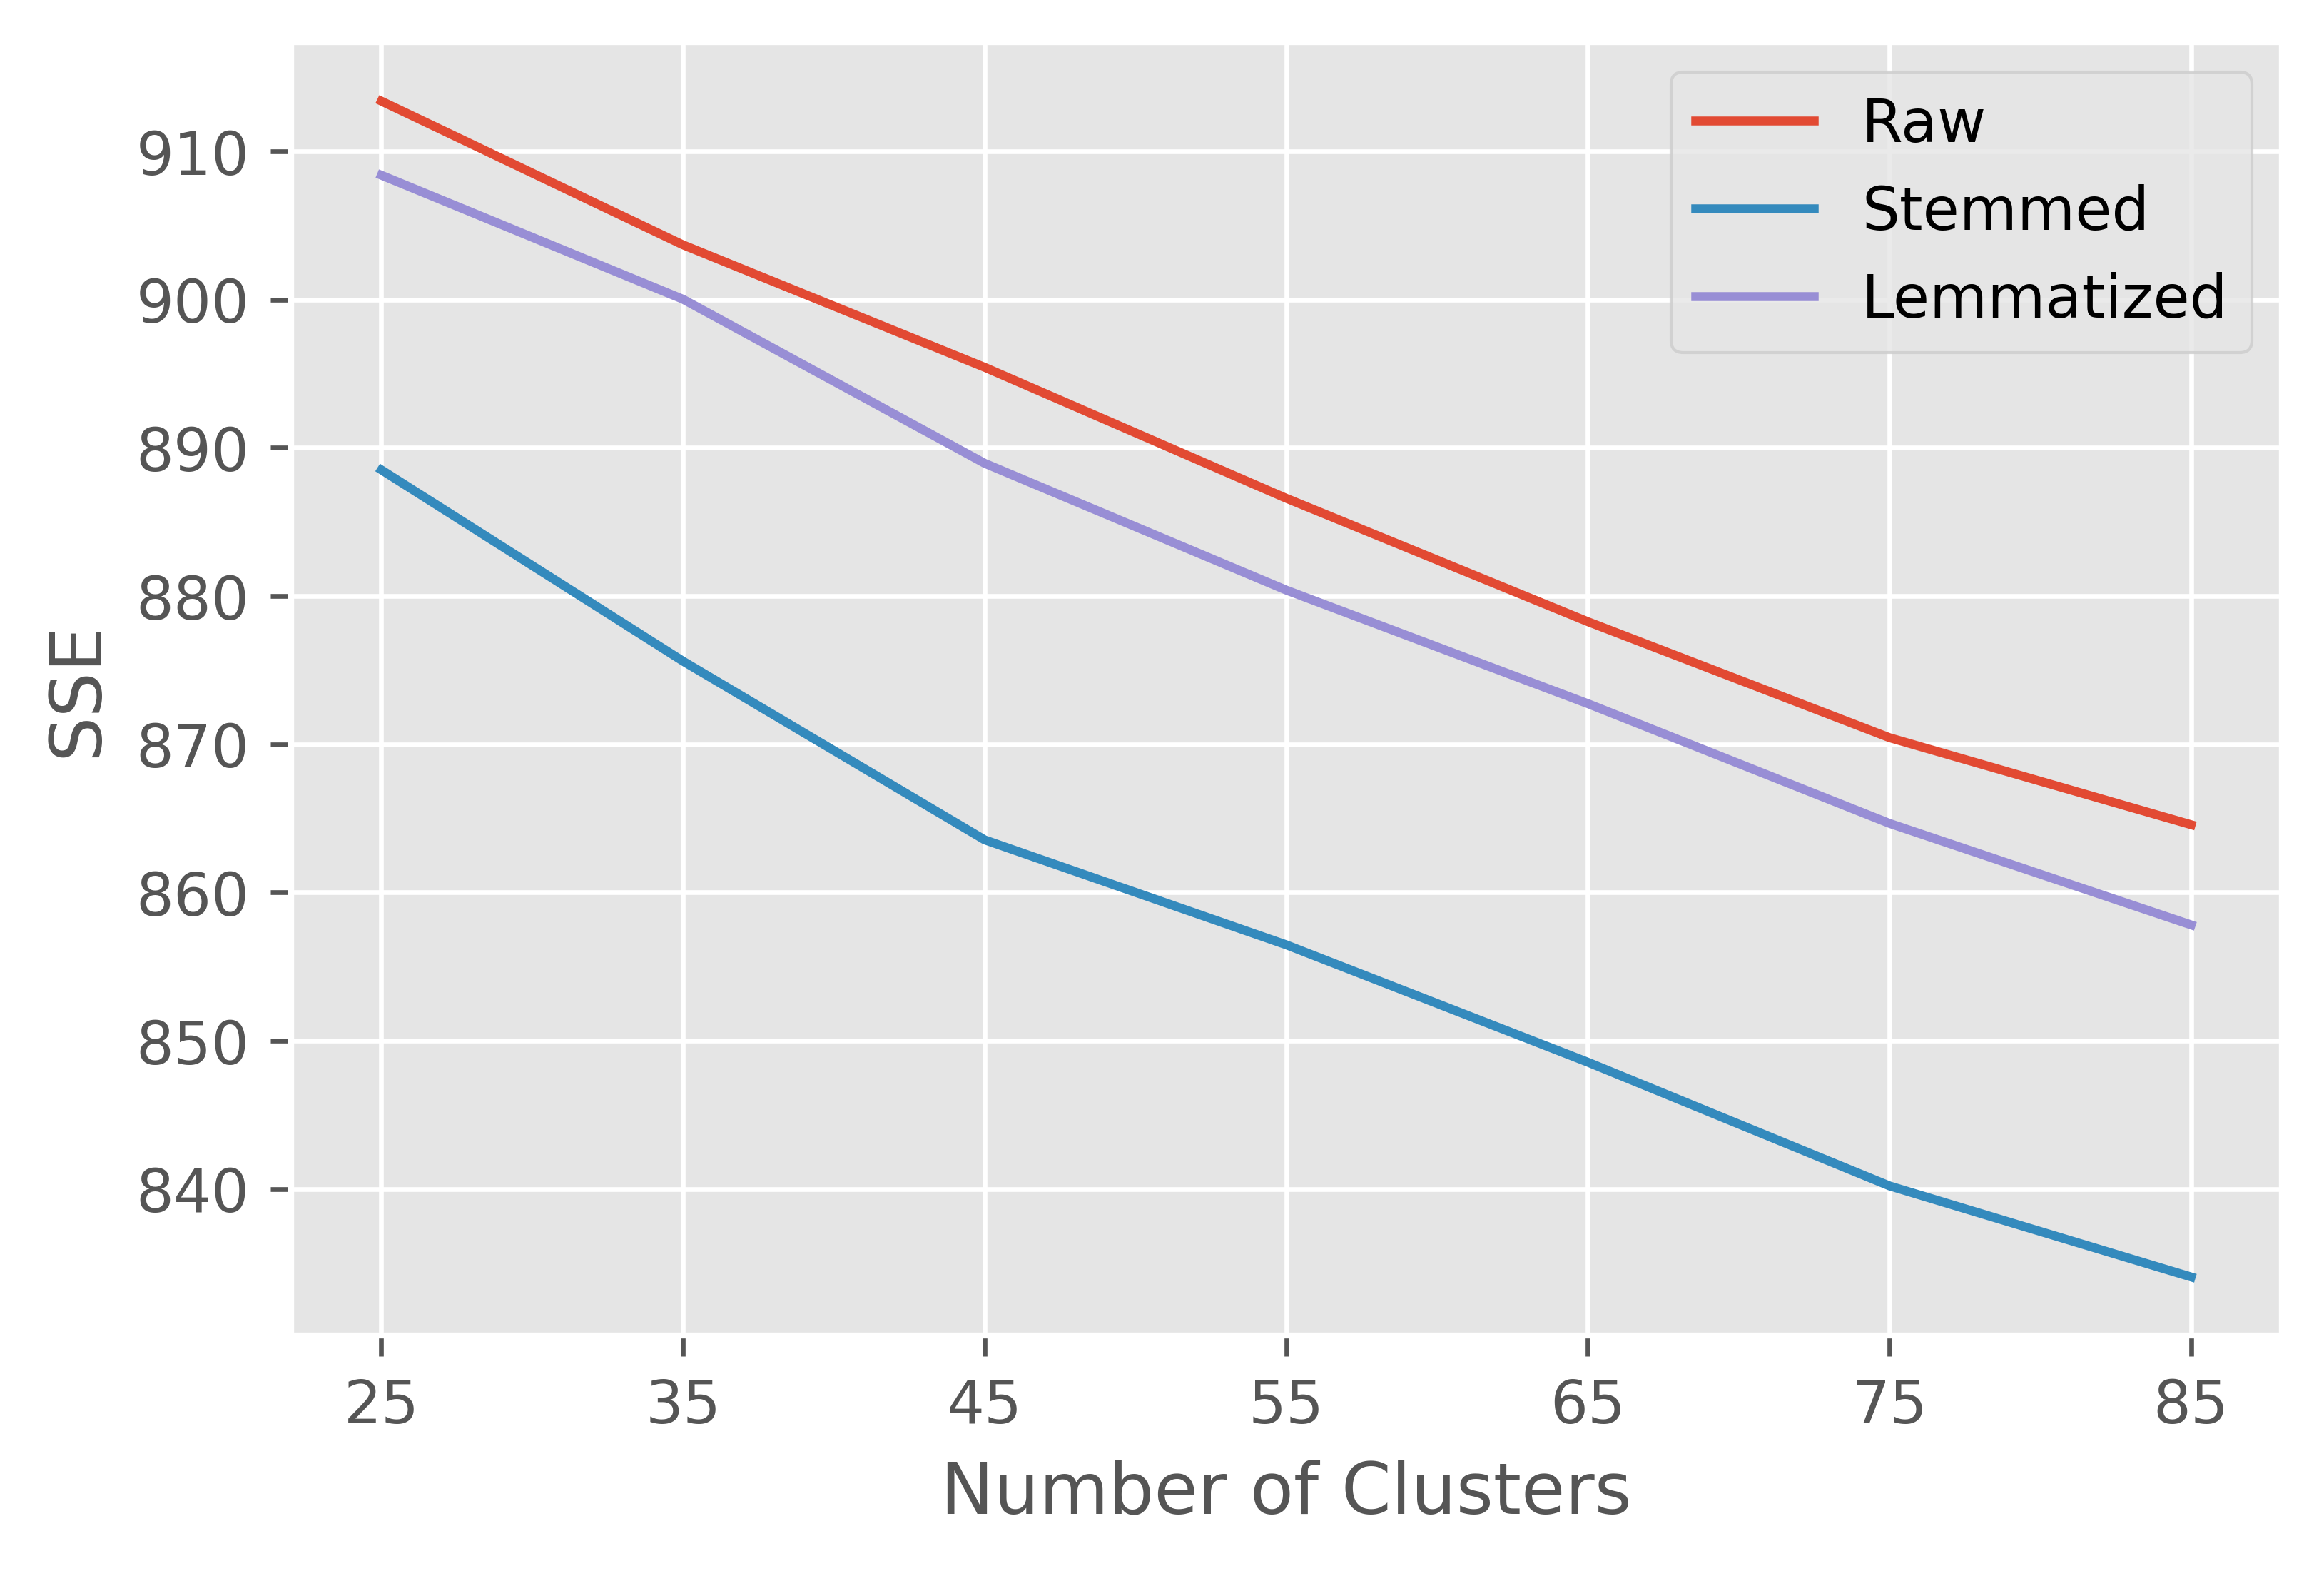

In [19]:
plt.style.use("ggplot")
plt.figure(dpi=600)
plt.xticks(range(25, 91, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.plot(range(25, 91, 10), km_raw, label = "Raw")
plt.plot(range(25, 91, 10), km_stemmed, label = "Stemmed")
plt.plot(range(25, 91, 10), km_lemmed, label = "Lemmatized")
plt.legend()
plt.show()